<a href="https://colab.research.google.com/github/AI-Junction/Histopathologic-Cancer-Detection/blob/master/Histopathologic-Cancer-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check memory allocation to this sesssion

In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   18G  323G   6% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  8.0K  6.4G   1% /var/colab
/dev/sda1       365G   22G  344G   6% /opt/bin
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Check RAM allocation in current session

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 149.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


Observe TensorFlow speedup on GPU relative to CPU

**** Uncomment below cell if needed

In [0]:
'''

import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

'''

'\n\nimport tensorflow as tf\nimport timeit\n\n# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth\nconfig = tf.ConfigProto()\nconfig.gpu_options.allow_growth = True\n\nwith tf.device(\'/cpu:0\'):\n  random_image_cpu = tf.random_normal((100, 100, 100, 3))\n  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)\n  net_cpu = tf.reduce_sum(net_cpu)\n\nwith tf.device(\'/gpu:0\'):\n  random_image_gpu = tf.random_normal((100, 100, 100, 3))\n  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)\n  net_gpu = tf.reduce_sum(net_gpu)\n\nsess = tf.Session(config=config)\n\n# Test execution once to detect errors early.\ntry:\n  sess.run(tf.global_variables_initializer())\nexcept tf.errors.InvalidArgumentError:\n  print(\n      \'\n\nThis error most likely means that this notebook is not \'\n      \'configured to use a GPU.  Change this in Notebook Settings via the \'\n      \'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n\')\n  raise\n\ndef cpu():\n  sess.run(ne

Check total memory allocation

*** Uncomment below cell only if needed

In [0]:
#!cat /proc/meminfo

Check versions of various libraries installed in this session of colaboratory

**** Uncomment below cell only if needed

In [0]:
'''

import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time

'''

'\n\nimport sys #access to system parameters https://docs.python.org/3/library/sys.html\nprint("Python version: {}". format(sys.version))\n\nimport pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features\nprint("pandas version: {}". format(pd.__version__))\n\nimport matplotlib #collection of functions for scientific and publication-ready visualization\nprint("matplotlib version: {}". format(matplotlib.__version__))\n\nimport numpy as np #foundational package for scientific computing\nprint("NumPy version: {}". format(np.__version__))\n\nimport scipy as sp #collection of functions for scientific computing and advance mathematics\nprint("SciPy version: {}". format(sp.__version__)) \n\nimport IPython\nfrom IPython import display #pretty printing of dataframes in Jupyter notebook\nprint("IPython version: {}". format(IPython.__version__)) \n\nimport sklearn #collection of machine learning algorithms\nprint("scikit-learn versio

In [4]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
#!ls -l /tmp

total 0


In [0]:
from colab_util import *
drive_handler = GoogleDriveHandler()

In [6]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!pip install kaggle

In [8]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
#filename = "/.kaggle/kaggle.json"
filename = "kaggle.json"
#os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [9]:
!ls -lha kaggle.json



---x-wx--T 1 root root 65 Dec 22 03:48 kaggle.json


In [10]:
os.path.isdir("/root/.kaggle")

False

In [11]:
dir_kaggle = "/root/.kaggle"
if not os.path.isdir(dir_kaggle):
  !mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/
os.path.isdir(dir_kaggle)

True

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

Create training and test data in this allocated session of colaboratory

In [0]:
!mkdir '/content/Histopathologic-Cancer-Detection'

In [0]:
if not os.path.isdir('/content/Histopathologic-Cancer-Detection/test'):
  !mkdir '/content/Histopathologic-Cancer-Detection/test'
  
if not os.path.isdir('/content/Histopathologic-Cancer-Detection/train'):
  !mkdir '/content/Histopathologic-Cancer-Detection/train'  

To copy file into colab from GCD

In [25]:
if not os.path.isfile('/content/Histopathologic-Cancer-Detection/test.zip'):
  !cp '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test.zip' '/content/Histopathologic-Cancer-Detection'
else:
  print('file exists')

file exists


In [27]:
import glob
HCDBaseDirTestDir_files = sorted(glob.glob('/content/Histopathologic-Cancer-Detection/test/*'))
#archived_files = [f for f in ipynb_files if int(f.split('/')[-1][:2]) % 2]
archived_files = [f for f in HCDBaseDirTestDir_files]
print(len(archived_files))
if len(archived_files) == 0:
  !unzip "/content/Histopathologic-Cancer-Detection/test.zip" -d "/content/Histopathologic-Cancer-Detection/test/"
else:
  print('already unzipped')


57458
already unzipped


In [20]:
import glob
HCDBaseDirTestDir_files = sorted(glob.glob('/content/Histopathologic-Cancer-Detection/test/*'))
#archived_files = [f for f in ipynb_files if int(f.split('/')[-1][:2]) % 2]
archived_files = [f for f in HCDBaseDirTestDir_files]
print(len(archived_files))

57458


In [22]:
!kaggle competitions files -c histopathologic-cancer-detection

name                   size  creationDate         
---------------------  ----  -------------------  
sample_submission.csv   2MB  2018-11-15 23:20:36  
train_labels.csv        9MB  2018-11-15 23:20:37  
test.zip                1GB  2018-11-15 23:21:06  
train.zip               5GB  2018-11-15 23:23:49  


In [0]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import glob


In [0]:
#GoogleDriveHandler?

In [0]:
gcd_ID = drive_handler.path_to_id('/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir')
gcd_ID
#drive_handler.list_folder(gcd_ID)

'1-LBsY5_fR4-SaS3C2e4qeRQEQ71lwnRU'

In [1]:
os.path.isdir('/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/')

NameError: ignored

In [0]:
#import glob
HCDBaseDirTrainDir_files = sorted(glob.glob('/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/*'))
#archived_files = [f for f in ipynb_files if int(f.split('/')[-1][:2]) % 2]
archived_files = [f for f in HCDBaseDirTrainDir_files]
print(len(archived_files))


#for f in archived_files:
#    print(f)

9000


In [0]:
print(type(archived_files))

<class 'list'>


In [0]:
archived_files[:10]

['/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/00030ae10b490d6f1b114bd7ea7a222889e61baa.tif',
 '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/0011a007b64a4a0f351ee4d7d00f237b1713b9bf.tif',
 '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/0029c1a7c3a114378a85794a63f4f80d68a00f0f.tif',
 '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/002cd118dfe80fa9872aedc5d7ab182d2ef378a1.tif',
 '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/00378803b945b044cbd74386a825dba2ccbb3ab7.tif',
 '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/0038ee22653a69294588be9707bc5009ecf546ce.tif',
 '/content/drive/My Drive/All ML Datasets/Hist

In [0]:
!mkdir '/content/Histopathologic-Cancer-Detection'

In [0]:
!mkdir '/content/Histopathologic-Cancer-Detection/base_dir'

In [0]:
#!rm -r '/content/Histopathologic-Cancer-Detection'

In [0]:
#!tar -cvf Histopathologic-Cancer-Detection.tar '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir'

In [0]:
!cp -r '/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir' '/content/Histopathologic-Cancer-Detection/base_dir'

^C


In [0]:
tar_file_path = create_archive('HCDBaseDirTrainDir', local_file_paths=archived_files[:10], verbose=True)
tar_file_path

ignore the common prefix /content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/
running shell command: 
tar -czvf /tmp/HCDBaseDirTrainDir.tar.gz -C /content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir/train_dir/a_no_tumor_tissue/ 00030ae10b490d6f1b114bd7ea7a222889e61baa.tif 0011a007b64a4a0f351ee4d7d00f237b1713b9bf.tif 0029c1a7c3a114378a85794a63f4f80d68a00f0f.tif 002cd118dfe80fa9872aedc5d7ab182d2ef378a1.tif 00378803b945b044cbd74386a825dba2ccbb3ab7.tif 0038ee22653a69294588be9707bc5009ecf546ce.tif 003c5b3b21c9d9d6a4e4ed6f69f090b0d5c1a403.tif 003fea1e13d1930e00960aec6b8e4b803cd70083.tif 006844f1d9b8455e2cbcac6247d5aafdd8d578a2.tif 00810a4651b1e3038c5fcfdb19e9b63625375ccd.tif


CalledProcessError: ignored

In [0]:
print([x for x in dir(GoogleDriveHandler)])

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'create_folder', 'download', 'list_folder', 'path_to_id', 'upload']


In [0]:
ipynb_files = sorted(glob.glob('sample_data/*.csv'))
#archived_files = [f for f in ipynb_files if int(f.split('/')[-1][:2]) % 2]
archived_files = [f for f in ipynb_files]
for f in archived_files:
    print(f)

sample_data/california_housing_test.csv
sample_data/california_housing_train.csv
sample_data/mnist_test.csv
sample_data/mnist_train_small.csv


In [0]:
tar_file_path = create_archive('sample_archive', local_file_paths=archived_files, verbose=True)
tar_file_path

ignore the common prefix sample_data/
running shell command: 
tar -czvf /tmp/sample_archive.tar.gz -C sample_data/ california_housing_test.csv california_housing_train.csv mnist_test.csv mnist_train_small.csv
california_housing_test.csv
california_housing_train.csv
mnist_test.csv
mnist_train_small.csv



'/tmp/sample_archive.tar.gz'

In [0]:
!ls -l '/tmp/sample_archive.tar.gz'

-rw-r--r-- 1 root root 7062290 Dec 19 10:50 /tmp/sample_archive.tar.gz


In [0]:
!ls -l '/tmp'

total 13800
-rw-r--r-- 1 root root 7062290 Dec 19 10:13 downloaded_archive.tar.gz
-rw-r--r-- 1 root root 7062290 Dec 19 10:50 sample_archive.tar.gz


In [0]:
test_folder_id = drive_handler.create_folder('test_folder')
test_folder_id

test_folder already exists


'1BaM2I087Vurb8JX-6Iv7lFy2f0-Fp_4N'

In [0]:
test_subfolder_id = drive_handler.create_folder('test_sub_folder', parent_path='test_folder')
test_subfolder_id

test_sub_folder already exists


'1TdEiSKD3G_MgA-En6p443EcKmg13Isxq'

In [0]:
same_subfolder_id = drive_handler.create_folder('test_sub_folder', parent_path='test_folder')
test_subfolder_id

test_sub_folder already exists


'1TdEiSKD3G_MgA-En6p443EcKmg13Isxq'

In [0]:
same_subfolder_id2 = drive_handler.create_folder('test_sub_folder2', parent_path='test_folder')
test_subsubfolder_id = drive_handler.create_folder('test_sub_sub_folder', parent_path='test_folder/test_sub_folder2')

test_sub_folder2 already exists
test_sub_sub_folder already exists


In [0]:
ID = drive_handler.path_to_id('test_folder/test_sub_folder2/test_sub_sub_folder')
ID, test_subsubfolder_id

('1kcyNGdUVFCHJqepAhC3hfNHqsoMXzsn5', '1kcyNGdUVFCHJqepAhC3hfNHqsoMXzsn5')

In [0]:
drive_handler.list_folder(test_folder_id)


[{'id': '16Of9NE7n94LkDU0ZLps_QTMJx4KWHNtZ',
  'link': 'https://drive.google.com/drive/folders/16Of9NE7n94LkDU0ZLps_QTMJx4KWHNtZ',
  'mimeType': 'application/vnd.google-apps.folder',
  'title': 'test_sub_folder2'},
 {'id': '1TdEiSKD3G_MgA-En6p443EcKmg13Isxq',
  'link': 'https://drive.google.com/drive/folders/1TdEiSKD3G_MgA-En6p443EcKmg13Isxq',
  'mimeType': 'application/vnd.google-apps.folder',
  'title': 'test_sub_folder'}]

In [0]:
drive_handler.list_folder(test_folder_id, max_depth=1)


[{'children': [{'id': '1DC1tDf_VIcI3LTBRFprKUyEa3aE5fB6S',
    'link': 'https://drive.google.com/file/d/1DC1tDf_VIcI3LTBRFprKUyEa3aE5fB6S/view?usp=drivesdk',
    'mimeType': 'application/x-tar',
    'title': 'sample_archive.tar.gz'},
   {'id': '1kcyNGdUVFCHJqepAhC3hfNHqsoMXzsn5',
    'link': 'https://drive.google.com/drive/folders/1kcyNGdUVFCHJqepAhC3hfNHqsoMXzsn5',
    'mimeType': 'application/vnd.google-apps.folder',
    'title': 'test_sub_sub_folder'}],
  'id': '16Of9NE7n94LkDU0ZLps_QTMJx4KWHNtZ',
  'link': 'https://drive.google.com/drive/folders/16Of9NE7n94LkDU0ZLps_QTMJx4KWHNtZ',
  'mimeType': 'application/vnd.google-apps.folder',
  'title': 'test_sub_folder2'},
 {'children': [],
  'id': '1TdEiSKD3G_MgA-En6p443EcKmg13Isxq',
  'link': 'https://drive.google.com/drive/folders/1TdEiSKD3G_MgA-En6p443EcKmg13Isxq',
  'mimeType': 'application/vnd.google-apps.folder',
  'title': 'test_sub_folder'}]

In [0]:
drive_handler.upload(tar_file_path, parent_path='test_folder/test_sub_folder2')
drive_handler.list_folder(test_folder_id, max_depth=1)

AttributeError: ignored

In [0]:
drive_handler.download('/tmp/downloaded_archive.tar.gz', target_path='test_folder/test_sub_folder2/sample_archive.tar.gz')

In [0]:
!ls -l '/tmp/'

total 13800
-rw-r--r-- 1 root root 7062290 Dec 19 10:51 downloaded_archive.tar.gz
-rw-r--r-- 1 root root 7062290 Dec 19 10:50 sample_archive.tar.gz


In [0]:
ipynb_files = sorted(glob.glob('sample_data/*.csv'))
#archived_files = [f for f in ipynb_files if int(f.split('/')[-1][:2]) % 2]
archived_files = [f for f in ipynb_files]
for f in archived_files:
    print(f)

In [0]:
'''
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))
'''

Uploaded file with ID 1raN3nk3otagKAkG3YQJgDCk5S_a6MLNf
Downloaded content "Sample upload file content"


In [0]:
! ls -l "/root"

total 0


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection")

True

In [0]:
os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip")

True

In [0]:
os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train")

True

In [0]:
if not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"):
  ! mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"



In [0]:
if not os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip"):
  !kaggle competitions download -c histopathologic-cancer-detection -f sample_submission.csv -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f test.zip -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"


In [0]:
if not os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv"):
  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"

In [0]:
'''
if not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"):
  !mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"
  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"
'''  

'\nif not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"):\n  !mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"\n  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"\n'

In [0]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 10000 # the number of images we use from each of the two classes

In [0]:
os.listdir('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection')

['train_labels.csv',
 'sample_submission.csv.zip',
 'train_labels.csv.zip',
 'test.zip',
 'train.zip',
 'train',
 'base_dir']

In [0]:
os.path.isfile('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv')

True

In [0]:
!chmod 600 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'

In [0]:
ls -l 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'

-rw------- 1 root root 9461084 Nov 15 23:48 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'


In [0]:
df_data = pd.read_csv('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv', engine='python')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [0]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [0]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            #print(file)
            im=cv2.imread(file)
            #print(im)
            #print(im.shape)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [0]:
import glob
train_files = glob.glob('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/*')

In [0]:
print(len(train_files))

38240


In [0]:
df_train_files = pd.DataFrame(train_files)

In [0]:
df_train_files.columns = ['filename']

In [0]:
df_train_files['tmp_col'] = 0

In [0]:
#df_data_new = df_data.loc[df['id'].isin(df_train_files)]

In [0]:
#df_train_files_tmp = df_train_files['filename'].split(".")

df_train_files_tmp = pd.DataFrame(df_train_files['filename'].apply(lambda x: x.split('.',1)))

In [0]:
df_train_files_tmp1 = [x[0] for x in df_train_files_tmp.filename[:]]

In [0]:
df_train_files_tmp1[0]

'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/fc0c2ae132d4f17d80f0b198581a1e886a35fca0'

In [0]:
print(type(df_train_files_tmp1))

<class 'list'>


In [0]:
df_train_files_tmp2 = pd.DataFrame(df_train_files_tmp1) #.apply(lambda x: x.split('/',1))
df_train_files_tmp2.columns = ['filename']

In [0]:
type(df_train_files_tmp2)

pandas.core.frame.DataFrame

In [0]:
df_train_files_tmp3 = pd.DataFrame(df_train_files_tmp2['filename'].apply(lambda x: x.split('/',-1)))

In [0]:
df_train_files_tmp4 = [x[-1] for x in df_train_files_tmp3.filename[:]]

In [0]:
df_train_files_tmp4[:10]

['fc0c2ae132d4f17d80f0b198581a1e886a35fca0',
 'c4ce898102407039d4898e2f729d2ce4e231f831',
 '134440349cc5493ad04af8d9b857cc82ac40d3f9',
 '19e7a455376c46550947ea283c4d09fd4290c1e7',
 '08995e1337711ab002ec5147ca3dec3707cfad61',
 'bac802732be72520cf5b8f57142c997f7aed79ef',
 '8870ac289778c26d22a475936d021983996be5e9',
 'f30bdba9a608c13fa695fd7d6ccf1c8275e8d140',
 '1fb4c37a19975f61cf3f2465283068641ec28432',
 '4ea74936ac8b273ff8e070deb70d4cd436a272fd']

In [0]:
df_data_new = df_data.loc[df_data['id'].isin(df_train_files_tmp4)]

In [0]:
df_data_new.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
14,94fa32b29cc1c00403176c0795fffa3cfaa0f20e,1
16,a1c001f6b242c72d3066f15ac6eb059ea72d30ba,0
18,730431efa2f79927156dcc4382819e9a6cc2c5bb,0


In [0]:
df_data_new.shape
df_data_new.columns
df_data_new.head()
df_data_new.id[:10]

0     f38a6374c348f90b587e046aac6079959adf3835
5     acfe80838488fae3c89bd21ade75be5c34e66be7
14    94fa32b29cc1c00403176c0795fffa3cfaa0f20e
16    a1c001f6b242c72d3066f15ac6eb059ea72d30ba
18    730431efa2f79927156dcc4382819e9a6cc2c5bb
22    4e1e69b64cdeb757178fc5b657b4e5ea07e53935
26    4e491f0beca3cc68b5013cbe726a9b358bf0f668
29    e6e31b49681a06c68aca9b64c42a4f002189a081
31    3fd6d45524adefa2b1210123b672fc84c9680f9e
37    9e565c87ee9077f325822a7322bf4dbc7f384ea8
Name: id, dtype: object

In [0]:
df_data_new = df_data_new.reset_index()

In [0]:
os.path.join('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train', df_data_new.id[10]+'.tif')

'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/8bdc54231f7239e2b5c66acb1341391ed651e56f.tif'

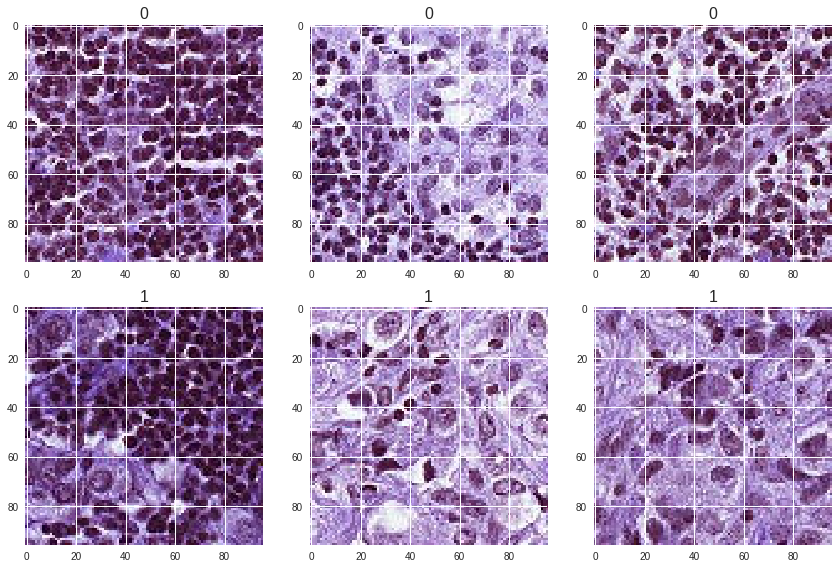

In [0]:
IMAGE_PATH = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/' 

draw_category_images('label',3, df_data_new, IMAGE_PATH)

In [0]:
print(SAMPLE_SIZE)

10000


In [0]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data_new[df_data_new['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data_new[df_data_new['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data_new = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data_new = shuffle(df_data_new)

df_data_new['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

In [0]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data_new['label']

df_train, df_val = train_test_split(df_data_new, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(18000, 3)
(2000, 3)


In [0]:
df_train['label'].value_counts()

1    9000
0    9000
Name: label, dtype: int64

In [0]:
df_val['label'].value_counts()

1    1000
0    1000
Name: label, dtype: int64

In [0]:
base_dir = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir'

In [0]:
'''
# Create a new directory
base_dir = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir'
os.mkdir(base_dir)
'''

"\n# Create a new directory\nbase_dir = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/base_dir'\nos.mkdir(base_dir)\n"

In [0]:
'''

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

'''

"\n\n#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]\n\n# now we create 2 folders inside 'base_dir':\n\n# train_dir\n    # a_no_tumor_tissue\n    # b_has_tumor_tissue\n\n# val_dir\n    # a_no_tumor_tissue\n    # b_has_tumor_tissue\n\n\n\n# create a path to 'base_dir' to which we will join the names of the new folders\n# train_dir\ntrain_dir = os.path.join(base_dir, 'train_dir')\nos.mkdir(train_dir)\n\n# val_dir\nval_dir = os.path.join(base_dir, 'val_dir')\nos.mkdir(val_dir)\n\n\n\n# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]\n# Inside each folder we create seperate folders for each class\n\n# create new folders inside train_dir\nno_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')\nos.mkdir(no_tumor_tissue)\nhas_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')\nos.mkdir(has_tumor_tissue)\n\n\n# create new folders inside val_dir\nno_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')\nos.mkdir(no_tumor_tissue)\nhas_tumor_tissue = os.path.join(val_di

In [0]:
'''
# check that the folders have been created
os.listdir(base_dir + '/train_dir')
'''

"\n# check that the folders have been created\nos.listdir(base_dir + '/train_dir')\n"

In [0]:
'''
# Set the id as the index in df_data
df_data_new.set_index('id', inplace=True)
'''

"\n# Set the id as the index in df_data\ndf_data_new.set_index('id', inplace=True)\n"

In [0]:
'''
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

train_src_dir = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train'

# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_new.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join(train_src_dir, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_new.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join(train_src_dir, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

'''
   

"\n# Get a list of train and val images\ntrain_list = list(df_train['id'])\nval_list = list(df_val['id'])\n\ntrain_src_dir = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train'\n\n# Transfer the train images\n\nfor image in train_list:\n    \n    # the id in the csv file does not have the .tif extension therefore we add it here\n    fname = image + '.tif'\n    # get the label for a certain image\n    target = df_data_new.loc[image,'label']\n    \n    # these must match the folder names\n    if target == 0:\n        label = 'a_no_tumor_tissue'\n    if target == 1:\n        label = 'b_has_tumor_tissue'\n    \n    # source path to image\n    src = os.path.join(train_src_dir, fname)\n    # destination path to image\n    dst = os.path.join(train_dir, label, fname)\n    # copy the image from the source to the destination\n    shutil.copyfile(src, dst)\n\n\n# Transfer the val images\n\nfor image in val_list:\n    \n    # the id in the csv file does not have the .tif extens

In [0]:
print(len(os.listdir(os.path.join(base_dir, 'train_dir','a_no_tumor_tissue'))))
print(len(os.listdir(os.path.join(base_dir, 'train_dir','b_has_tumor_tissue'))))

9000
9000


In [0]:
print(len(os.listdir(os.path.join(base_dir, 'val_dir','a_no_tumor_tissue'))))
print(len(os.listdir(os.path.join(base_dir, 'val_dir','b_has_tumor_tissue'))))

1000
1000


In [0]:
train_path = base_dir + '/train_dir'
valid_path = base_dir + '/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print(num_train_samples)
print(num_val_samples)

18000
2000


In [0]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 41, 41, 64)        36928     
__________

In [0]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [0]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
   6/1800 [..............................] - ETA: 2:22:18 - loss: 0.6966 - acc: 0.4500